# Assignment 7: Neural Networks and Backpropagation
In this assignment, you will be asked to write your own code to implement the learning process of a simple neural network. We will use a simple version of [MNIST dataset](http://yann.lecun.com/exdb/mnist/), which we have introduced in Assignment 5. To make the problem simpler, we only take images with label '8' and '9', which gives us a binary classification problem. Then we subsample the dataset and reduce the dimension of each image using average pooling. The following code loads the dataset and prints its dimension.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
#Load data
import scipy.io as sio
a = sio.loadmat('mnist_binary.mat')
X_trn = a['X_trn']
X_tst = a['X_tst']
Y_trn = a['Y_trn'][0]
Y_tst = a['Y_tst'][0]
print(X_trn.shape)
print(X_tst.shape)
print(Y_trn.shape)
print(Y_tst.shape)

(196, 964)
(196, 414)
(964,)
(414,)


## Requirements
1. You are not allowed to use any machine learning libraries which have neural networks implemented.

2. Notice here most of the problems you have will be regarding the dimensions of variables. In each skeleton function we provide, we have one assert line to help you verify whether you write your code correctly. Passing the assert line doesn't mean your code is correct. But it is a necessary condition.

3. You don't need to strictly follow the skeleton we provide. As long as you answer the problems correctly, you can write in any style you prefer.

## Parameters
Let's first implement a simple neural network with one hidden layer and one output layer. The hidden layer only has $n_h$ neurons. We assume the output layer has two neurons. Hence you will have 4 parameters to describe the neural network: 

1. $W_1$, a $n_h$ by 196 matrix, which is the weight matrix between features and the hidder layer.
2. $b_1$, a scalar, which is the offset for the first layer.
3. $W_2$, a 2 by $n_h$ matrix, which is the weight matrix between the hidder layer and the output layer.
4. $b_2$, a scalar, which is the offset for the second layer.

The following script initializes the above four parameters and returns them as a dictionary.

In [2]:
#Initialize parameters 
num_hidden = 20 #number of neurons in the hidden layer
num_op = 2 #number of neurons in the output layer

def initialize_parameters(size_input, size_hidden, size_output):
    np.random.seed(2)
    W1 = np.random.randn(size_hidden, size_input) * 0.01
    b1 = np.zeros(shape=(size_hidden, 1))
    W2 = np.random.randn(size_output, size_hidden) * 0.01
    b2 = np.zeros(shape=(size_output, 1))
    parameters = {'W1': W1,
                  'b1': b1,
                  'W2': W2,
                  'b2': b2}
    return parameters
parameters = initialize_parameters(X_trn.shape[0], num_hidden, num_op)
print('W1',parameters['W1'].shape)
print('b1',parameters['b1'].shape)
print('W2',parameters['W2'].shape)
print('b2',parameters['b2'].shape)

W1 (20, 196)
b1 (20, 1)
W2 (2, 20)
b2 (2, 1)


## Softmax function.
Given the output layer $z_1, z_2$. The softmax outputs are probability estimates for outputing the corresponding label:

$$Pr(Y = 1 | z_1, z_2) = \frac{e^{z_1}}{e^{z_1} + e^{z_2}}$$

Write code in the cell below to do the softmax computation. Note here Z2 should be a matrix of shape $2 \times n$, where $n$ is the number of training samples. Your output softmax should be of the same size.

In [30]:
def softmax(Z2):
    # ip - (M,N) array where M is no. of neurons in output layer, N is number of samples.
    # You can modify the code if your output layer is of different dimension
   # =========Write your code below ==============
    import math
    z1 = Z2[0]
    z2 = Z2[1]
    softmax = np.zeros((Z2.shape[0],Z2.shape[1]))
    softmax[0] = math.e ** z1 / (math.e ** z1 + math.e ** z2)
    softmax[1] = math.e ** z2 / (math.e ** z1 + math.e ** z2)
    # =============================================
    assert(softmax.shape == Z2.shape)
    return softmax

## Activation function.
The following function should be able to implement activation function given the input.

 <ol>
     <li>ReLU: $\sigma(z) = \max(0, z)$</li>
     <li>Sigmoid: $\sigma(z) = \frac{1}{1 + e^{-z}}$</li>
 </ol>

In [186]:
def activ(ip,act):
    # ip - array obtained after multiplying inputs with weights (between input layer and hidden layer)
    # act - ReLU or Sigmoid
    if act =="ReLU":
        # =========Write your code below ==============
        f = lambda z: np.maximum(0, z)
        out = np.maximum(ip, 0)
    # =============================================
    elif act == "Sigmoid":
        # =========Write your code below ==============
        f = lambda z: 1/(1+np.exp(-z))
        out = 1/(1+np.exp(-ip))
    # =============================================
    assert(out.shape == ip.shape)
    return out

## Forward Propagation
Given $X, W_1, b_1, W_2, b_2$, the following function will compute the neurons and activated values in the hidden layer, denoted by $Z_1, A_1$ respectively. It will also return the neurons in the last layer and the softmax function computed from it, denoted by $Z_2, A_2$ respectively.

In [183]:
#Forward Propagation   
def forward_propagation(X, parameters, act):
    
# =========Write your code below ==============
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
#     print("W1 shape {}， X shape {}, b1 shape{}".format(W1.shape, X.shape, b1.shape))
    Z1 = np.dot(W1, X)+b1
    A1 = activ(Z1, act)
    Z2 = np.dot(W2, A1)+b2
    A2 = softmax(Z2)
    # =============================================
    
    assert(A2.shape == (2, X.shape[1]))
    
    neuron = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    return neuron

## Backward propagation
In this assignment, we will use the cross-entropy loss defined below as our loss function. Let $\hat{y}$ be the outputs after the softmax layer corresponding to label 8 and let $y$ be the true labels (assume 1 for '8', 0 for '9')
$$L(y,\hat{y}) = \frac{1}{m}\sum\limits_{i=1}^{m} -y_i\log(\hat{y}_i) - (1-y_i)\log(1-\hat{y}_i).$$

Given the parameters and the neuron values, we can calculate the derivative of the loss function w.r.t all the parameters $W_1, b_1, W_2, b_2$ using backward propagation. Note here, all the gradients should be of the same dimension as the corresponding parameters. 

In [196]:
def backprop(parameters, neuron, X, Y, act):
    
# =========Write your code below ==============
    Z1 = neuron['Z1'] 
    Z2 = neuron['Z2']
    A1 = neuron['A1'] # 20 * n
    A2 = neuron['A2'] # 2 * n
    W1 = parameters['W1'] # 28 * 196
    b1 = parameters['b1']
    W2 = parameters['W2'] # 2 * 20
    b2 = parameters['b2']
    
    #Initiate dy and calculate dW2
    dy = np.zeros(A2.shape)
    dy[0] = -Y / A2[0] + (1 - Y) / (1 - A2[0])
    dy[0] /= len(Y)
    dy[1] = Y / (1 - A2[1]) - (1 - Y) / A2[1]
    dy[1] /= len(Y)
    dy *= (A2 - A2 ** 2) # 2 * n
    dW2 = np.dot(dy, A1.T)
    
    db2 = np.sum(dy, axis = 1).reshape(len(b2),1)
#     print("db2 shape{}".format(db2.shape))
    dA1 = np.dot(W2.T, dy)
    
    if act =="ReLU":
        dA1[Z1 <= 0] = 0
        dA1[Z1 > 0] *= 1
    elif act == "Sigmoid":
        s  = 1 / (1 + np.exp(-Z1))
        dA1 *= (1 - s)*s
    db1 = np.sum(dA1, axis = 1).reshape(len(b1),1)
#     print("db1 shape{}".format(db1.shape))
    dW1 = np.dot(dA1, X.T)

    # =============================================
    
    assert(dW1.shape == W1.shape)
    assert(dW2.shape == W2.shape)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads
#print(backprop(parameters, neuron, X_trn, Y_trn, act='Sigmoid')['dW1'].shape)
#print(backprop(parameters, neuron, X_trn, Y_trn, act='Sigmoid')['dW2'].shape)
#print(backprop(parameters, neuron, X_trn, Y_trn, act='Sigmoid')['db1'].shape)
#print(backprop(parameters, neuron, X_trn, Y_trn, act='Sigmoid')['db2'].shape)

def cross_entropy_loss(softmax, Y):
# =========Write your code below ==============
    loss = 0.0
    for i in range(len(Y)):
        loss += -Y[i] * np.log(softmax[0, i]) - (1 - Y[i]) * np.log(1 - softmax[0, i])
    loss /= softmax.shape[0]
# =============================================        
   # assert(loss.shape = Y.shape) As required by TA
    return loss

## Parameter updates
Given the parameters and the gradients, we simply update the parameters by the following:

$$W = W - \eta dW$$

where $\eta$ is the learning rate.

In [178]:
def update_parameters(parameters, grads, learning_rate):

# =========Write your code below ==============
    W1 = parameters['W1'] - learning_rate * grads['dW1']
    b1 = parameters['b1'] - learning_rate * grads['db1']
    W2 = parameters['W2'] - learning_rate * grads['dW2']
    b2 = parameters['b2'] - learning_rate * grads['db2']

# =============================================

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

## Neural network models
Combining the above mentioned parameters, implement the following function to learn a neural network and do inference on it. For prediction, you take the argument that gives the largest softmax output at the last layer.

In [132]:
from sklearn.metrics import accuracy_score
def nn_model1(X_trn, X_tst, Y_trn, Y_tst, n_h, n_o, epochs, act, learning_rate):
    #X_trn: the training set
    #X_tst: the test set
    #Y_trn: training labels
    #Y_tst: test labels
    #n_h: number of neurons in the hidden layer
    #n_o: number of neurons in the output layer
    #epochs: number of epochs for the training
    #act: the activation function you choose
    #learning_rate: a list of length epochs, which consists of the learning rate in each step
    
    assert(len(learning_rate) == epochs)
    
   # =========Write your code below ==============
    err_tst = np.zeros(epochs)
    err_trn = np.zeros(epochs)
    loss_trn = np.zeros(epochs)
    parameters = initialize_parameters(X_trn.shape[0], n_h, n_o)
    for i in range(epochs): 
        neuron = forward_propagation(X_trn, parameters, act)
        grads = backprop(parameters, neuron, X_trn, Y_trn, act)
        A2 = neuron['A2']
        Y_trn_pre = np.zeros(len(Y_trn))
        for j in range(len(Y_trn)):
            if A2[0, j] > A2[1,j]:
                Y_trn_pre[j] = 1
        err_trn[i] = 1 - accuracy_score(Y_trn_pre, Y_trn)
        loss_trn[i] = cross_entropy_loss(A2, Y_trn)
        neuron2 = forward_propagation(X_tst, parameters, act)
        A2 = neuron2['A2']
        Y_tst_pre = np.zeros(len(Y_tst))
        for j in range(len(Y_tst)):
            if A2[0, j] > A2[1, j]:
                Y_tst_pre[j] = 1
        err_tst[i] = 1 - accuracy_score(Y_tst_pre, Y_tst)
        parameters = update_parameters(parameters, grads, learning_rate[i])

    # =============================================    
    #err_tst: testing error (classification error) in each epoch
    #err_trn: training error (classification error) in each epoch
    #loss_trn: training loss (cross entropy loss) in each epoch
    #parameters: the final learned parameters
    return err_tst, err_trn, loss_trn, parameters

## Problem 0: Verify that your code is working well.
Using ReLU (Sigmoid) as your activation function, implement a learning algorithm with fixed learning rate $\eta = 0.01$ at each step. Set the number of epochs to be 20000. Plot the cross entropy loss at each epoch to convince yourself that you are training well. (Your cross entropy loss should be decreasing smoothly. This part won't be graded.)

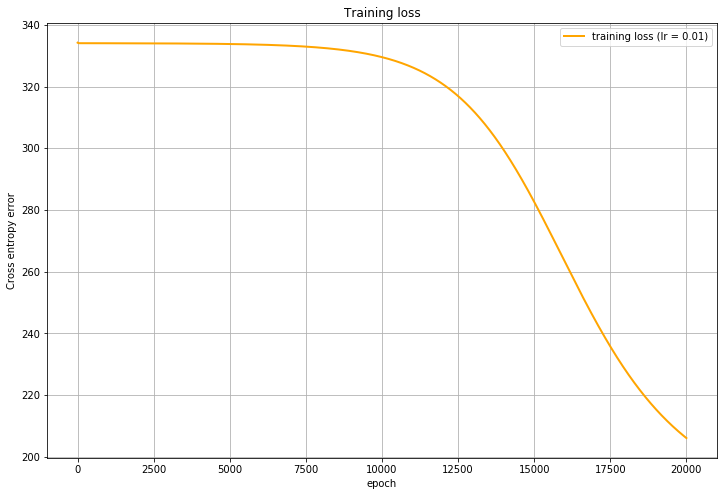

In [188]:
epochs = 20000
lr1 = 0.01*np.ones(epochs)
# =========Write your code below ==============
act = 'Sigmoid'
err_tst, err_trn, loss_trn, parameters = nn_model1(X_trn, X_tst, Y_trn, Y_tst, num_hidden, num_op, epochs, act, lr1)

# =============================================
plt.figure(1, figsize=(12, 8))
plt.plot(range(epochs), loss_trn, '-', color='orange',linewidth=2, label='training loss (lr = 0.01)')
plt.title('Training loss')
plt.xlabel('epoch')
plt.ylabel('Cross entropy error')
plt.legend(loc='best')
plt.grid()
plt.show()

# Problem 1: Learning with fixed learning rate.
Using ReLU as your activation function, implement a learning algorithm with fixed learning rate $\eta = 0.01$ at each step. Plot the training and testing error (classification error) you get at each epoch. Justify your plot. (Set the number of hidden neurons in the hidden layer to be 20 for problem 1-3, for all problems below, set epochs = 20000).

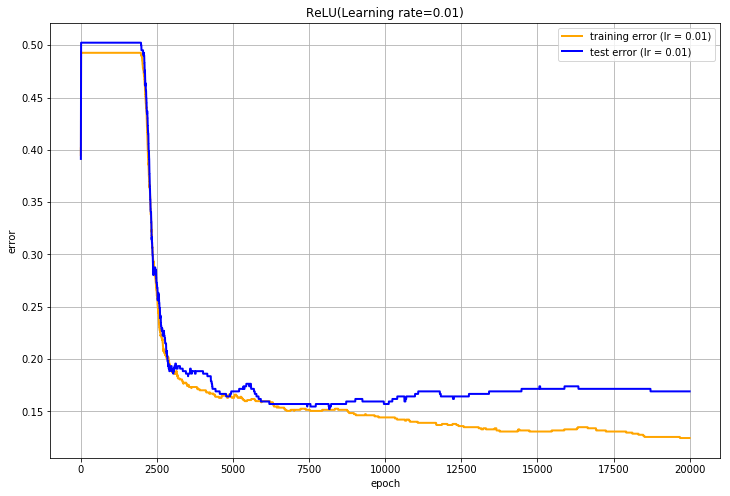

In [197]:
epochs = 20000
lr1 = 0.01*np.ones(epochs)
# =========Write your code below ==============
act = 'ReLU'
err_tst, err_trn, loss_trn, parameters = nn_model1(X_trn, X_tst, Y_trn, Y_tst, 
                                                   num_hidden, num_op, epochs, act, lr1)

# =============================================
plt.figure(1, figsize=(12, 8))
plt.plot(range(epochs), err_trn, '-', color='orange',linewidth=2, label='training error (lr = 0.01)')
plt.plot(range(epochs), err_tst, '-b', linewidth=2, label='test error (lr = 0.01)')
#plt.plot(range(epochs), trn_loss, '-r', linewidth=2, label='loss (lr = 0.01)')

plt.title('ReLU(Learning rate=0.01)')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend(loc='best')
plt.grid()
plt.show()

# Problem 2: 
Using ReLU as your activation function, change the learning rate to $\eta = 0.1$. Plot the plots on the same figure as in problem 1. Compare the plots and justify.

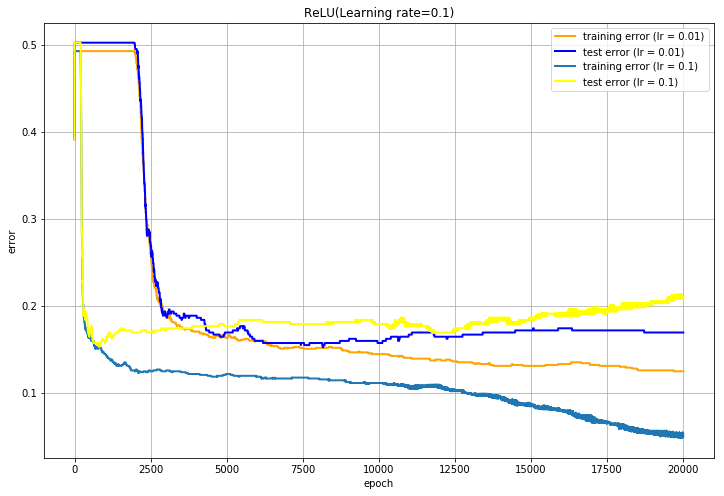

In [198]:
lr2 = 0.1*np.ones(epochs)
# =========Write your code below ==============

act = 'ReLU'
err_tst2, err_trn2, loss_trn2, parameters = nn_model1(X_trn, X_tst, Y_trn, Y_tst, 
                                                   num_hidden, num_op, epochs, act, lr2)

# =============================================
plt.figure(2, figsize=(12, 8))
# Classification errors for learning rate = 0.01, Relu Activation, n_hidden = 20
plt.plot(range(epochs), err_trn, '-', color='orange',linewidth=2, label='training error (lr = 0.01)')
plt.plot(range(epochs), err_tst, '-b', linewidth=2, label='test error (lr = 0.01)')

# Classification errors for learning rate = 0.1, Relu Activation, n_hidden = 20
plt.plot(range(epochs), err_trn2, '-', linewidth=2, label='training error (lr = 0.1)')
plt.plot(range(epochs), err_tst2, '-b', color='yellow', linewidth=2,  label='test error (lr = 0.1)')

plt.title('ReLU(Learning rate=0.1)')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend(loc='best')
plt.grid()
plt.show()

# Problem 3: Learning with variable learning rate.
Using ReLU as your activation function, implement a learning algorithm with variable learning rate $\eta = \frac1{\sqrt{i+1}}$ at the $i$th step. Plot the training and testing error you get at each iteration and compare it with the plots you get previously. Justify your plot.

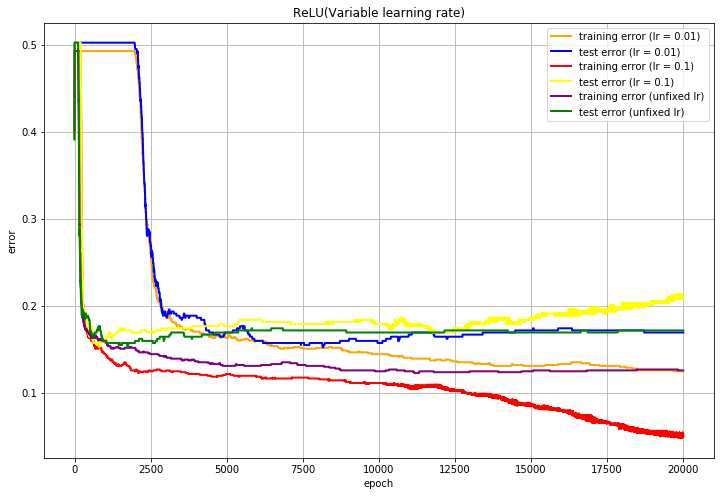

In [199]:
indices = np.array(range(epochs))
lr3 = 1/np.sqrt(indices + 1)
# =========Write your code below ==============

act = 'ReLU'
err_tst3, err_trn3, loss_trn3, parameters = nn_model1(X_trn, X_tst, Y_trn, Y_tst, 
                                                   num_hidden, num_op, epochs, act, lr3)


# =============================================
plt.figure(3, figsize=(12, 8))
# Classification errors for learning rate = 0.01, Relu Activation, n_hidden = 20
plt.plot(range(epochs), err_trn, '-', color='orange',linewidth=2, label='training error (lr = 0.01)')
plt.plot(range(epochs), err_tst, '-b', linewidth=2, label='test error (lr = 0.01)')

# Classification errors for learning rate = 0.1, Relu Activation, n_hidden = 20
plt.plot(range(epochs), err_trn2, '-', color='red', linewidth=2, label='training error (lr = 0.1)')
plt.plot(range(epochs), err_tst2, '-b', color='yellow', linewidth=2, label='test error (lr = 0.1)')

# Classification errors for variable learning rate, Relu Activation, n_hidden = 20
plt.plot(range(epochs), err_trn3, '-', color='purple', linewidth=2, label='training error (unfixed lr)')
plt.plot(range(epochs), err_tst3, '-b', color='green', linewidth=2, label='test error (unfixed lr)')
plt.title('ReLU(Variable learning rate)')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend(loc='best')
plt.grid()
plt.show()

# Problem 4: Larger hidden layer.
Change the number of neurons in the hidden layer to be $50$. Redo the experiment in problem 1. Plot all four plots in the same figure and justify your plot.

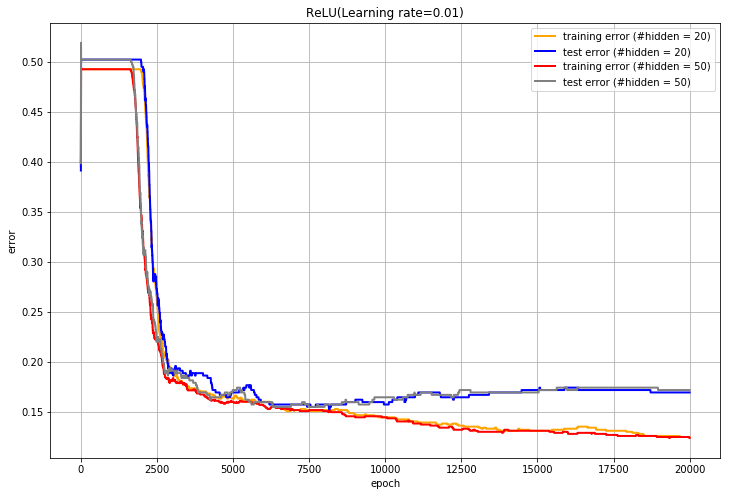

In [200]:
num_hidden2 = 50
# =========Write your code below ==============
act = 'ReLU'
err_tst4, err_trn4, loss_trn4, parameters = nn_model1(X_trn, X_tst, Y_trn, Y_tst, num_hidden2, 
                                                      num_op, epochs, act, lr1)


# =============================================
plt.figure(4, figsize=(12, 8))
# Classification errors for learning rate = 0.01, Relu Activation, n_hidden = 20
plt.plot(range(epochs), err_trn, '-', color='orange',linewidth=2, label='training error (#hidden = 20)')
plt.plot(range(epochs), err_tst, '-b', linewidth=2, label='test error (#hidden = 20)')

# Classification errors for learning rate = 0.01, Relu Activation, n_hidden = 50
plt.plot(range(epochs), err_trn4, '-', color='red', linewidth=2, label='training error (#hidden = 50)')
plt.plot(range(epochs), err_tst4, '-b', color='grey', linewidth=2, label='test error (#hidden = 50)')

plt.title('ReLU(Learning rate=0.01)')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend(loc='best')
plt.grid()
plt.show()

# Problem 5: Sigmoid Activation.
Change the activation function to be 
function. Redo the experiment in problem 1. Plot all four plots in the same figure and justify your plot.

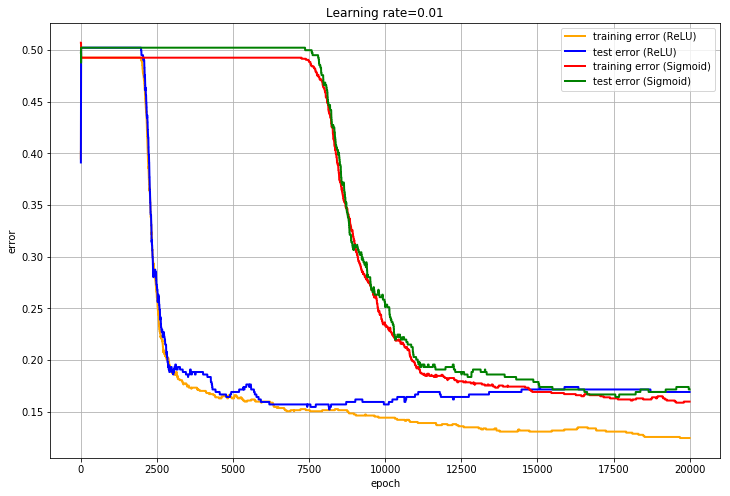

In [201]:
# =========Write your code below ==============
act = 'Sigmoid'
err_tst5, err_trn5, loss_trn5, parameters = nn_model1(X_trn, X_tst, Y_trn, Y_tst, num_hidden2, 
                                                      num_op, epochs, act, lr1)

# =============================================
# Classification errors for learning rate = 0.01, Relu Activation, n_hidden = 20
plt.figure(5, figsize=(12, 8))
plt.plot(range(epochs), err_trn, '-', color='orange',linewidth=2, label='training error (ReLU)')
plt.plot(range(epochs), err_tst, '-b', linewidth=2, label='test error (ReLU)')

# Classification errors for learning rate = 0.01, Sigmoid Activation, n_hidden = 20
plt.plot(range(epochs), err_trn5, '-', color='red',  linewidth=2, label='training error (Sigmoid)')
plt.plot(range(epochs), err_tst5, '-b', color='green', linewidth=2, label='test error (Sigmoid)')

plt.title('Learning rate=0.01')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend(loc='best')
plt.grid()
plt.show()

In [195]:
err_tst2

array([0.39130435, 0.50241546, 0.50241546, ..., 0.50241546, 0.50241546,
       0.50241546])